In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df = pd.read_csv('datasets/insurance.csv')

# Análisis exploratorio

In [13]:
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [14]:
print('El dataset tiene {} columnas y {} filas'.format(df .shape[1], df.shape[0]))

El dataset tiene 7 columnas y 1338 filas


¿Cuál es la naturaleza de los datos?

In [15]:
print('Información del dataframe:\n')
df.info()

Información del dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


No tenemor valores nulos.

Tipo de los datos:
* **int64**: age, children.
* **float64**: bmi, expenses.
* **object**: sex, smoker, region 

# Análisis de datos

Analizaremos los efectos que tienen los atributos sobre la variable objetivo `expenses`

In [16]:
def atributos_vs_objetivo(atributo, objetivo, dataframe):
    """Crea una tabla resumen del promedio del atributo en contra del objetivo y devuelve un dataframe.

    Args:
        atributo ([List]): [Atributo a analizar]
        objetivo ([List]): [Variable objetivo]
        dataframe ([DataFrame]): [Dataframe a analizar]

    Returns:
        tabla ([DataFrame]): [Tabla con el promedio de cada atributo en contra del objetivo]
    """
    tabla = dataframe[[atributo, objetivo]].groupby(atributo, as_index=False).mean().sort_values(by=objetivo, ascending=False).style.background_gradient(cmap='Blues')
    return tabla  

In [17]:
sex_expenses = atributos_vs_objetivo('sex', 'expenses', df)
sex_expenses

,sex,expenses
1,male,13956.751420
0,female,12569.578897


En promedio los hombres deben desembolsar más dinero a la hora de contratar un seguro de salud.

In [18]:
children_expenses = atributos_vs_objetivo('children', 'expenses', df)
children_expenses

,children,expenses
3,3,15355.318535
2,2,15073.564000
4,4,13850.656800
1,1,12731.171821
0,0,12365.975767
5,5,8786.035556


En promedio, las familiar deben pagar más dinero al tener entre 2 y 4 hijos.

In [19]:
smoker_expenses = atributos_vs_objetivo('smoker', 'expenses', df)
smoker_expenses

,smoker,expenses
1,yes,32050.231971
0,no,8434.268449


Las personas fumadoras pagan en promedio casi 4 veces lo que paga una persona no fumadora, lo cual puede tener mucha influencia a la hora de modelarlo.

In [20]:
region_expenses = atributos_vs_objetivo('region', 'expenses', df)
region_expenses

,region,expenses
2,southeast,14735.411538
0,northeast,13406.384691
1,northwest,12417.575169
3,southwest,12346.937908


La región más cara es 'southeast' y por el contrario la más barata es 'southwest' 

In [21]:
df[['region', 'sex', 'bmi', 'expenses']].groupby(['region'], as_index=False).mean().sort_values(by=['expenses'], ascending=False).style.background_gradient(cmap='Blues')

,region,bmi,expenses
2,southeast,33.359341,14735.411538
0,northeast,29.176235,13406.384691
1,northwest,29.201846,12417.575169
3,southwest,30.596615,12346.937908


In [22]:
# Anlisis bmi ranges
bmi_ranges = np.where(df['bmi'] < 18.5, 'bajo peso', 
             np.where(df['bmi'] < 25, 'peso normal', 
             np.where(df['bmi'] < 30, 'sobrepeso', 
             'obesidad')))

Rangos de bmi, según [NHS](https://www.nhs.uk/common-health-questions/lifestyle/what-is-the-body-mass-index-bmi/)

In [23]:
df['bmi_range'] = bmi_ranges

In [24]:
bmi_range_table = atributos_vs_objetivo('bmi_range', 'expenses', df)
bmi_range_table

,bmi_range,expenses
1,obesidad,15552.335728
3,sobrepeso,11000.079306
2,peso normal,10379.499775
0,bajo peso,8852.201500


Los costos de los seguros de salud son más caros, mientras mayor índice de masa corporal tenga la persona.

# Visualización de los datos

Visualizaremos las variables del dataset y sacaremos información.

## Sex

<AxesSubplot:xlabel='sex', ylabel='count'>

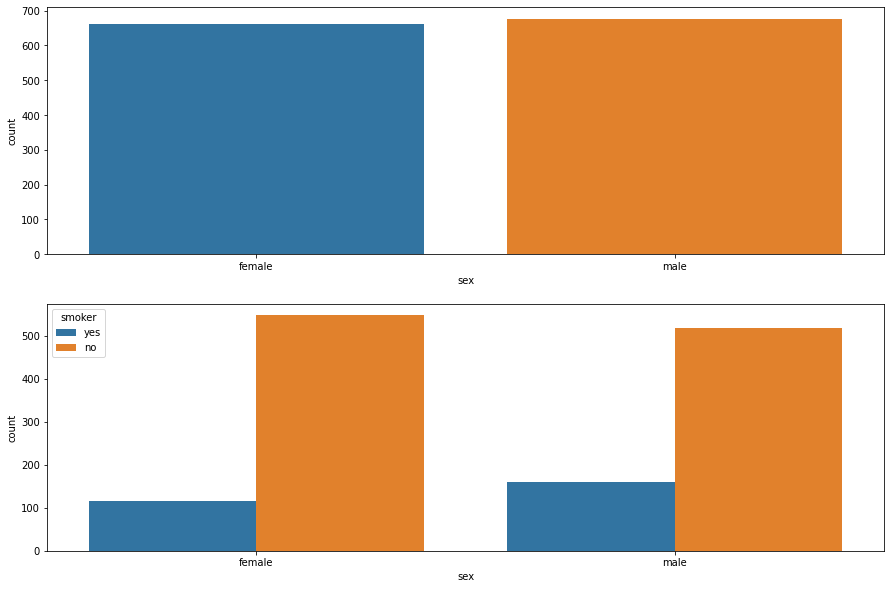

In [25]:
fig, ax = plt.subplots(2, figsize=(15,10))
sns.countplot(ax=ax[0] , x='sex', data=df)
sns.countplot(ax=ax[1] , x='sex', data =df, hue='smoker')

* Hay una cantidad muy similas de hombres y mujeres en el dataset.
* La proporción de fumadores es similas en ambos sexos, sin embargo los hombres tienen un mayor porcentaje de fumadores que las mujeres.

## Age

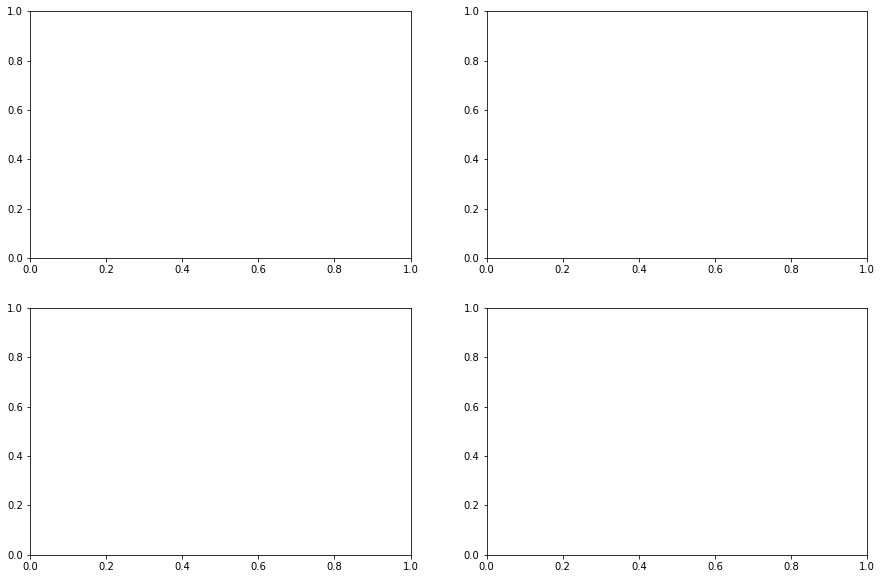

In [26]:
fig, ax = plt.subplots(2,2, figsize =(15,10))
